In [1]:
# Importing libraries

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import itertools as it
import matplotlib.pyplot as plt

from datetime import datetime
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

plt.rc('font', size=16)

import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers

# Setting random seed for reproducibility

seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
tfp.random.sanitize_seed(seed)

2022-09-17 08:16:41.253711: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 08:16:41.353411: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 08:16:41.354168: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-17 08:16:41.356070: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([2083866985, -350068510], dtype=int32)>

In [2]:
# Opening the dataframe
ABB_data = pd.read_csv('../input/electricitydemand/Multivariate_Labeled_2 (1).csv', parse_dates=['DateTime'], delimiter=',')
ABB_data.drop(columns="DateTime", inplace=True)
ABB_data

,CB_First_Floor,CB_Second_Floor,AvgT,AvgH,Anomaly_Label,Year,Month,Day,Hour,Min,Sec,Day_Of_The_Week
0,37.0,36.0,4.70,80.40,0.0,2017.0,2.0,9.0,0.0,0.0,0.0,3.0
1,32.0,33.0,4.75,79.35,0.0,2017.0,2.0,9.0,0.0,15.0,0.0,3.0
2,32.0,32.0,4.60,78.90,0.0,2017.0,2.0,9.0,0.0,30.0,0.0,3.0
3,32.0,33.0,4.50,79.25,0.0,2017.0,2.0,9.0,0.0,45.0,0.0,3.0
4,33.0,33.0,4.40,80.40,0.0,2017.0,2.0,9.0,1.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
75835,41.0,41.0,10.95,83.25,0.0,2019.0,4.0,9.0,22.0,45.0,0.0,1.0
75836,42.0,42.0,10.80,84.60,0.0,2019.0,4.0,9.0,23.0,0.0,0.0,1.0
75837,43.0,43.0,10.65,86.05,0.0,2019.0,4.0,9.0,23.0,15.0,0.0,1.0
75838,42.0,42.0,10.30,86.90,0.0,2019.0,4.0,9.0,23.0,30.0,0.0,1.0


In [3]:
# Dataframe preprocessing

# Converting data types
ABB_data['CB_First_Floor'] = ABB_data['CB_First_Floor'].astype(np.float32)
ABB_data['CB_Second_Floor'] = ABB_data['CB_Second_Floor'].astype(np.float32)
ABB_data['AvgT'] = ABB_data['AvgT'].astype(np.float32)
ABB_data['AvgH'] = ABB_data['AvgH'].astype(np.float32)
ABB_data['Anomaly_Label'] = ABB_data['Anomaly_Label'].astype(np.float32)
ABB_data['Year'] = ABB_data['Year'].astype(np.float32)
ABB_data['Month'] = ABB_data['Month'].astype(np.float32)
ABB_data['Day'] = ABB_data['Day'].astype(np.float32)
ABB_data['Hour'] = ABB_data['Hour'].astype(np.float32)
ABB_data['Min'] = ABB_data['Min'].astype(np.float32)
ABB_data['Sec'] = ABB_data['Sec'].astype(np.float32)
ABB_data['Day_Of_The_Week'] = ABB_data['Day_Of_The_Week'].astype(np.float32)

# Printing the dataframe's info
ABB_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75840 entries, 0 to 75839
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CB_First_Floor   75840 non-null  float32
 1   CB_Second_Floor  75840 non-null  float32
 2   AvgT             75840 non-null  float32
 3   AvgH             75840 non-null  float32
 4   Anomaly_Label    75840 non-null  float32
 5   Year             75840 non-null  float32
 6   Month            75840 non-null  float32
 7   Day              75840 non-null  float32
 8   Hour             75840 non-null  float32
 9   Min              75840 non-null  float32
 10  Sec              75840 non-null  float32
 11  Day_Of_The_Week  75840 non-null  float32
dtypes: float32(12)
memory usage: 3.5 MB


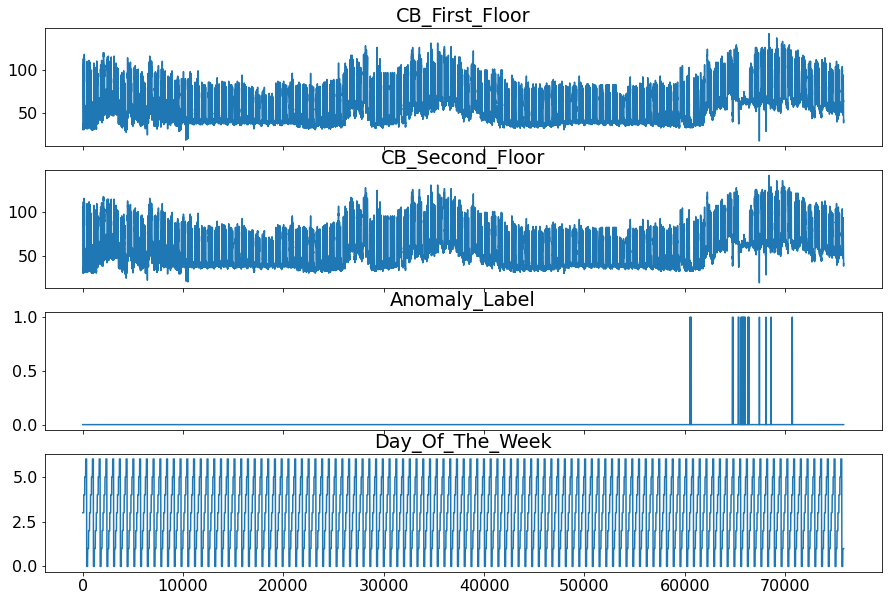

In [4]:
# Function used to plot time series
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(15,10))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
    
# Plotting time series
inspect_dataframe(ABB_data[["CB_First_Floor", "CB_Second_Floor", "Anomaly_Label", "Day_Of_The_Week"]], ABB_data[["CB_First_Floor", "CB_Second_Floor", "Anomaly_Label", "Day_Of_The_Week"]].columns)

In [5]:
# Columns used for the following split in train, test and validation sets
ABB_data['Test'] = 0
ABB_data['Validation'] = 0
ABB_data['Train_P1'] = 0
ABB_data['Train_P2'] = 0

In [6]:
# TEST SET

# Some random weeks
week = [89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111]
for j in week:
    Slice_Multivariate_data = ABB_data.iloc[(j)*672:(j+1)*672]
    for k in range((j)*672,((j+1)*672)):
        ABB_data.at[k, 'Test'] = 1
        
j=112
for k in range((j)*672,((j+1)*672)-96):
        ABB_data.at[k, 'Test'] = 1

In [7]:
# VALIDATION SET

# Some random weeks
week = [55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78]
for j in week:
    Slice_Multivariate_data = ABB_data.iloc[(j)*672:(j+1)*672]
    for k in range((j)*672,(j+1)*672):
        ABB_data.at[k, 'Validation'] = 1

In [8]:
# TRAINING SET

week = [x for x in np.arange(0, 55, 1)]
for j in week:
    Slice_Univariate_data = ABB_data.iloc[(j)*672:(j+1)*672]
    for k in range((j)*672,(j+1)*672):
        ABB_data.at[k, 'Train_P1'] = 1
    
week = [x for x in np.arange(79, 89, 1)]
for j in week:
    Slice_Univariate_data = ABB_data.iloc[(j)*672:(j+1)*672]
    for k in range((j)*672,(j+1)*672):
        ABB_data.at[k, 'Train_P2'] = 1

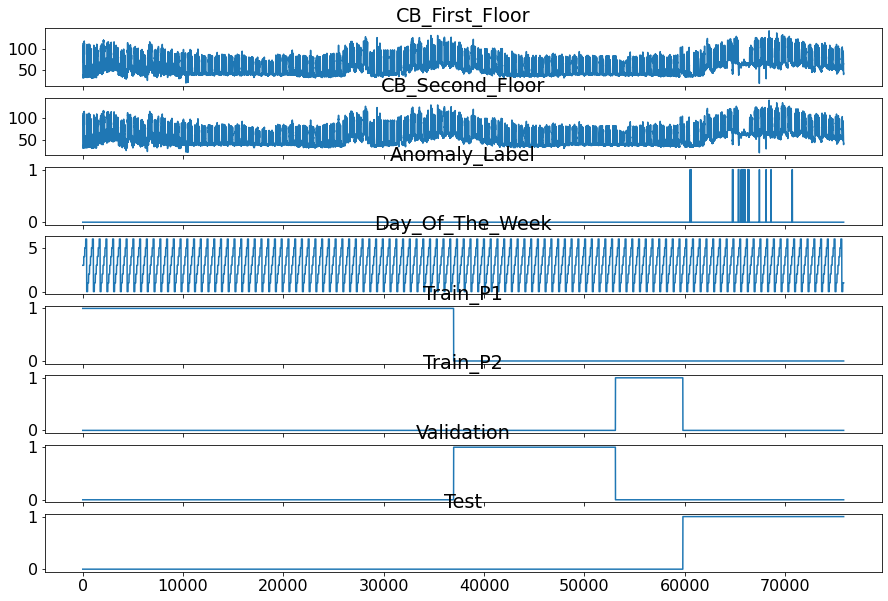

In [9]:
# Plotting time series
inspect_dataframe(ABB_data[["CB_First_Floor", "CB_Second_Floor", "Anomaly_Label", "Day_Of_The_Week", "Train_P1", "Train_P2", "Validation", "Test"]], ABB_data[["CB_First_Floor", "CB_Second_Floor", "Anomaly_Label", "Day_Of_The_Week", "Train_P1", "Train_P2", "Validation", "Test"]].columns)

In [10]:
# TRAIN, TEST, VALIDATION SETS
X_train_temp_P1 = ABB_data[ABB_data['Train_P1']==1].copy()
X_train_temp_P2 = ABB_data[ABB_data['Train_P2']==1].copy()
X_validation_temp = ABB_data[ABB_data['Validation']==1].copy()
X_test_temp = ABB_data[ABB_data['Test']==1].copy()

In [11]:
# Training, Validation and Test set - Anomalies (not used for training)
Anomaly_Train_P1 = X_train_temp_P1[['Anomaly_Label']]
Anomaly_Train_P2 = X_train_temp_P2[['Anomaly_Label']]
Anomaly_Validation = X_validation_temp[['Anomaly_Label']]
Anomaly_Test = X_test_temp[['Anomaly_Label']]

In [12]:
Anomaly_Test.isna().sum()

Anomaly_Label    0
dtype: int64

In [13]:
X_train_temp_global = pd.concat([X_train_temp_P1,X_train_temp_P2],axis=0)
X_train_temp_global.shape

(43680, 16)

In [14]:
# STANDARDIZATION

mean = X_train_temp_global.mean()
std_dev = X_train_temp_global.std()
print(mean, std_dev)

X_train_raw_P1 = (X_train_temp_P1-mean)/std_dev
X_train_raw_P2 = (X_train_temp_P2-mean)/std_dev
X_validation_raw = (X_validation_temp-mean)/std_dev
X_test_raw = (X_test_temp-mean)/std_dev

print(X_test_raw.shape[0]+X_validation_raw.shape[0]+X_train_raw_P1.shape[0]+X_train_raw_P2.shape[0] == ABB_data.shape[0])

CB_First_Floor       56.138874
CB_Second_Floor      55.814743
AvgT                 14.077893
AvgH                 71.934387
Anomaly_Label         0.000000
Year               2017.283569
Month                 6.725275
Day                  15.931869
Hour                 11.500000
Min                  22.500000
Sec                   0.000000
Day_Of_The_Week       3.000000
Test                  0.000000
Validation            0.000000
Train_P1              0.846154
Train_P2              0.153846
dtype: float64 CB_First_Floor     19.434896
CB_Second_Floor    19.353765
AvgT                8.412517
AvgH               19.357885
Anomaly_Label       0.000000
Year                0.450710
Month               3.393199
Day                 8.644081
Hour                6.922266
Min                16.770702
Sec                 0.000000
Day_Of_The_Week     2.000023
Test                0.000000
Validation          0.000000
Train_P1            0.360805
Train_P2            0.360805
dtype: float64
True


In [15]:
# Anomalies are not considered during the training
X_train_raw_P1 = X_train_raw_P1[['CB_First_Floor', 'CB_Second_Floor', 'Day_Of_The_Week']]
X_train_raw_P2 = X_train_raw_P2[['CB_First_Floor', 'CB_Second_Floor', 'Day_Of_The_Week']]
X_validation_raw = X_validation_raw[['CB_First_Floor', 'CB_Second_Floor', 'Day_Of_The_Week']]
X_test_raw = X_test_raw[['CB_First_Floor', 'CB_Second_Floor', 'Day_Of_The_Week']]
X_train_raw_P1.shape, X_train_raw_P2.shape, X_validation_raw.shape, X_test_raw.shape

((36960, 3), (6720, 3), (16128, 3), (16032, 3))

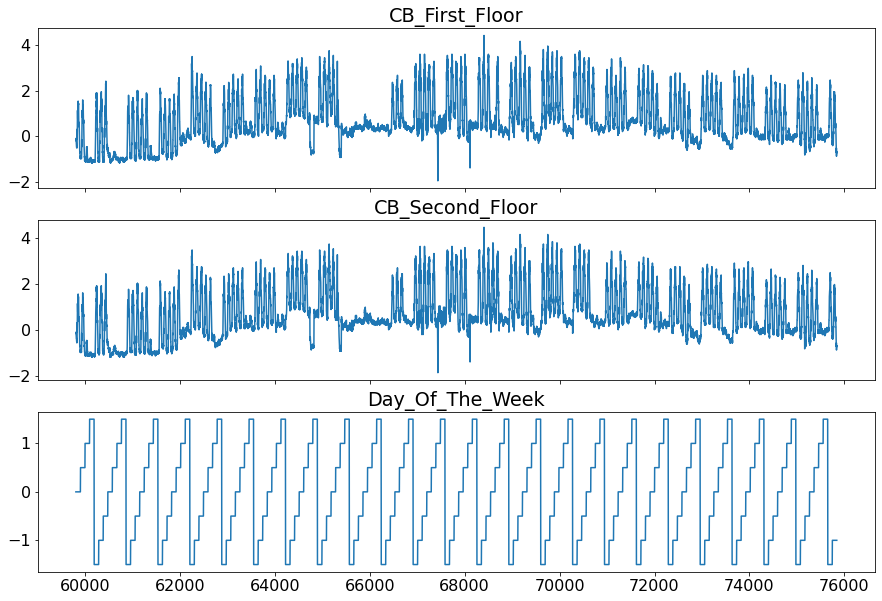

In [16]:
# Plotting time series
inspect_dataframe(X_test_raw, X_test_raw.columns)

## Training Preparation

In [17]:
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
tfp.random.sanitize_seed(seed)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([2083866985, -350068510], dtype=int32)>

In [18]:
# Training parameters

window = 672       # 1 week
stride = 8         # 1 hour
latent_dim = 10    # Latent dimension
epochs = 500       # Number of epochs (no early stopping)
batch_size = 8     # Batch size
alpha = 0.5
M = 100
noise_factor = [0.2, 0.2, 0.2]

In [19]:
# Function used to create (overlapped) windows that we will use for the training
def build_sequences(df, anomaly, window=window, stride=stride):
    
    assert len(df) > window
    dataset = []
    anomalies = []
    temp_df = df.copy().values
    temp_an = anomaly.copy().values
    padding_len = (len(df)-window)%stride # Padding computed considering the stride
    print("PADDING: " + str(padding_len)) #DEBUG

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float32')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_an.shape[1]), dtype='float32')
        temp_an = np.concatenate((padding,temp_an))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window+1,stride):
        dataset.append(temp_df[idx:idx+window])
        anomalies.append(temp_an[idx:idx+window])

    dataset = np.array(dataset)
    anomalies = np.array(anomalies)
    return dataset, anomalies

In [20]:
X_train_P1, A_train_P1 = build_sequences(X_train_raw_P1, Anomaly_Train_P1, window=window, stride=stride)
X_train_P2, A_train_P2 = build_sequences(X_train_raw_P2, Anomaly_Train_P2, window=window, stride=stride)
X_val, A_val = build_sequences(X_validation_raw, Anomaly_Validation, window=window, stride=stride)
X_train_P1.shape,X_train_P2.shape

PADDING: 0
PADDING: 0
PADDING: 0


((4537, 672, 3), (757, 672, 3))

In [21]:
# Temp test set - plotting purposes
X_test, A_test = build_sequences(X_test_raw, Anomaly_Test, window=window, stride=stride)

PADDING: 0


In [22]:
X_train = np.concatenate([X_train_P1,X_train_P2],axis=0)
A_train = np.concatenate([A_train_P1,A_train_P2],axis=0)
X_train.shape, A_train.shape

((5294, 672, 3), (5294, 672, 1))

## Building the model

In [23]:
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [24]:
# Reparametrization trick
def sample_z1(args):
    z_mean, z_log_var = args
    eps = tf.keras.backend.random_normal(shape=(K.shape(z_mean)[0], K.int_shape(z_mean)[1]))
    return z_mean + tf.exp(alpha * z_log_var) * eps

# Reparametrization trick
def sample_z2(args):
    z_mean, z_log_var = args
    eps = tf.keras.backend.random_normal(shape=(K.shape(z_mean)[0], K.int_shape(z_mean)[1], K.int_shape(z_mean)[2]))
    return z_mean + tf.exp(alpha * z_log_var) * eps

In [25]:
class AddNoise(tfk.layers.Layer):
    
    def call(self, inputs):
        data, noise_factor = inputs
        noise = tf.map_fn(fn=lambda t: tf.random.normal((672,3), 0, 1)*noise_factor, elems=data)
        noise_input = data + noise
        
        return noise_input

In [26]:
class SimScore(tfk.layers.Layer):

    def call(self, inputs):
        seq, h_dim = inputs  # seq: batch x x_dim x h_dim*2

        S = tf.map_fn(fn=lambda t: tf.linalg.matmul(tf.transpose(t), t), elems=seq) # batch x h_dim x h_dim
        S = tf.map_fn(fn=lambda t: t / tf.math.sqrt((tf.cast(h_dim*2, dtype=tf.float32))), elems=S)
        A = tf.map_fn(fn=lambda t: tf.keras.activations.softmax(t), elems=S)
        C = tf.matmul(seq, A)

        return C

In [27]:
# Building the model

from keras import backend as K
from tensorflow.keras import Input
attention_dim = 10

input_shape = X_train.shape[1:]
output_shape = X_train.shape[1:]

###########
# ENCODER #
###########

encoder_input = tf.keras.Input(shape=input_shape)

noisy_input = AddNoise()([encoder_input, noise_factor])

h_seq, forward_h, forward_c, backward_h, backward_c = tfkl.Bidirectional(tfkl.LSTM(72, activation='tanh', return_sequences=True, return_state=True))(noisy_input)

state_h = tfkl.Concatenate()([forward_h, backward_h])

Cdet = SimScore()([h_seq, window])

c_mean = tfkl.Dense(attention_dim , activation='linear', name="c_mean")(Cdet)
c_log_var = tfkl.Dense(attention_dim , activation='softplus', name="c_var")(Cdet)

# Latent representation: mean + log of std.dev.
z_mean = tfkl.Dense(latent_dim, activation='linear', name="z_mean")(state_h)
z_log_var = tfkl.Dense(latent_dim, activation='softplus', name="z_var")(state_h)

# Sampling a vector from the latent distribution
z = tfkl.Lambda(sample_z1, name='z')([z_mean, z_log_var])
c = tfkl.Lambda(sample_z2, name='c')([c_mean, c_log_var])

encoder = tfk.Model(encoder_input, [z_mean, z_log_var, z, c_mean, c_log_var, c], name='encoder')
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 672, 3)]     0                                            
__________________________________________________________________________________________________
add_noise (AddNoise)            (None, 672, 3)       0           input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 672, 144), ( 43776       add_noise[0][0]                  
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 144)          0           bidirectional[0][1]              
                                                                 bidirectional[0][3]        

In [28]:
###########
# DECODER #
###########

z_inputs = Input(shape=(latent_dim, ), name='decoder_input_1')
c_inputs = Input(shape=(window, attention_dim), name='decoder_input_2')

repeated = tfkl.RepeatVector(window)(z_inputs)
concat = tfkl.Concatenate(axis=-1)([repeated, c_inputs])

x = tfkl.Bidirectional(tfkl.LSTM(72, return_sequences=True))(concat)

# OPZIONE 1 - Dense Layers come nel paper
mu = tfkl.Dense(3, activation='linear', name="mu")(x)
log_sigma = tfkl.Dense(3, activation='softplus', name="sigma")(x)

# Define and summarize decoder model
decoder = tfk.Model([z_inputs, c_inputs], [mu, log_sigma], name='decoder')
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input_1 (InputLayer)    [(None, 10)]         0                                            
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 672, 10)      0           decoder_input_1[0][0]            
__________________________________________________________________________________________________
decoder_input_2 (InputLayer)    [(None, 672, 10)]    0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 672, 20)      0           repeat_vector[0][0]              
                                                                 decoder_input_2[0][0]      

In [29]:
class VAE(tfk.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tfk.metrics.Mean(name="total_loss")
        self.likelihood_tracker = tfk.metrics.Mean(name="likelihood")
        self.kl_loss_z_tracker = tfk.metrics.Mean(name="kl_loss_z")
        self.kl_loss_c_tracker = tfk.metrics.Mean(name="kl_loss_c")
        self.reconstruction_loss_tracker = tfk.metrics.Mean(name="reconstruction_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.likelihood_tracker,
            self.kl_loss_z_tracker,
            self.kl_loss_c_tracker,
            self.reconstruction_loss_tracker
        ]
    

    def train_step(self, data):
        with tf.GradientTape() as tape:
            
            sample = None
            encoder_mu, encoder_log_var, z, c_mean, c_log_var, c = self.encoder(data)
            decoder_mu, decoder_log_sigma = self.decoder([z,c])
            decoder_sigma = tf.exp(decoder_log_sigma)
            
            pdf_laplace = tfp.distributions.Laplace(decoder_mu, decoder_sigma, validate_args=True, name='Laplace')
                        
            for _ in range(M):
                sample = pdf_laplace.sample() if sample is None else sample + pdf_laplace.sample()
                             
            likelihood = -(pdf_laplace.log_prob(data))
            likelihood = tf.reduce_mean(likelihood, axis=-1)
            likelihood = tf.reduce_mean(likelihood, axis=-1)
                
            decoder_output = sample/M
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tfk.losses.mse(data, decoder_output), axis=1))
            
            kl_loss_z = -0.5 * (1 + encoder_log_var - tf.square(encoder_mu) - tf.exp(encoder_log_var))
            kl_loss_z = tf.reduce_mean(tf.reduce_sum(kl_loss_z, axis=1))
            
            kl_loss_c = -0.5 * (1 + c_log_var - tf.square(c_mean) - tf.exp(c_log_var))
            kl_loss_c = tf.keras.backend.sum(kl_loss_c, axis=1)
            kl_loss_c = tf.reduce_mean(kl_loss_c, axis=1)

            total_loss = 4*likelihood + 2*(kl_loss_z + 6*kl_loss_c) + reconstruction_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.likelihood_tracker.update_state(likelihood)
        self.kl_loss_z_tracker.update_state(kl_loss_z)
        self.kl_loss_c_tracker.update_state(kl_loss_c)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "likelihood": self.likelihood_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result()
        }
    
    
    
    def test_step(self, data): # https://github.com/keras-team/keras-io/issues/38

        sample = None
        encoder_mu, encoder_log_var, z, c_mean, c_log_var, c = self.encoder(data)
        decoder_mu, decoder_log_sigma = self.decoder([z,c])
        decoder_sigma = tf.exp(decoder_log_sigma)
            
        pdf_laplace = tfp.distributions.Laplace(decoder_mu, decoder_sigma, validate_args=True, name='Laplace')
                        
        for _ in range(M):
            sample = pdf_laplace.sample() if sample is None else sample + pdf_laplace.sample()
                             
        likelihood = -(pdf_laplace.log_prob(data))
        likelihood = tf.reduce_mean(likelihood, axis=-1)
        likelihood = tf.reduce_mean(likelihood, axis=-1)
                
        decoder_output = sample/M
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tfk.losses.mse(data, decoder_output), axis=1))
            
        kl_loss_z = -0.5 * (1 + encoder_log_var - tf.square(encoder_mu) - tf.exp(encoder_log_var))
        kl_loss_z = tf.reduce_mean(tf.reduce_sum(kl_loss_z, axis=1))
            
        kl_loss_c = -0.5 * (1 + c_log_var - tf.square(c_mean) - tf.exp(c_log_var))
        kl_loss_c = tf.keras.backend.sum(kl_loss_c, axis=1)
        kl_loss_c = tf.reduce_mean(kl_loss_c, axis=1)

        total_loss = 4*likelihood + 2*(kl_loss_z + 6*kl_loss_c) + reconstruction_loss
            
        self.total_loss_tracker.update_state(total_loss)
        self.likelihood_tracker.update_state(likelihood)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_z_tracker.update_state(kl_loss_z)
        self.kl_loss_c_tracker.update_state(kl_loss_c)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "likelihood": self.likelihood_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_c": self.kl_loss_c_tracker.result(),
            "kl_z": self.kl_loss_z_tracker.result(),
        }

In [30]:
vae = VAE(encoder, decoder)

seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

vae.compile(optimizer=tfk.optimizers.Adam())

vae.fit(x = X_train,
        validation_data = (X_val, None),
        epochs=epochs, 
        batch_size=batch_size,
        callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True), tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-5)]
       )

2022-09-17 08:16:50.006122: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500


2022-09-17 08:17:09.425039: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


662/662 [==============================] - 134s 172ms/step - loss: 632.5095 - likelihood: 1.1908 - reconstruction_loss: 239.4027 - val_loss: 224.9924 - val_likelihood: 1.0270 - val_reconstruction_loss: 136.8838 - val_kl_c: 6.9505 - val_kl_z: 0.3031
Epoch 2/500
662/662 [==============================] - 109s 164ms/step - loss: 238.0595 - likelihood: 1.0320 - reconstruction_loss: 145.8718 - val_loss: 192.9961 - val_likelihood: 0.9816 - val_reconstruction_loss: 115.2086 - val_kl_c: 6.0915 - val_kl_z: 0.3580
Epoch 3/500
662/662 [==============================] - 108s 164ms/step - loss: 210.7092 - likelihood: 0.9991 - reconstruction_loss: 128.4363 - val_loss: 178.7606 - val_likelihood: 0.9895 - val_reconstruction_loss: 121.1057 - val_kl_c: 4.4574 - val_kl_z: 0.1067
Epoch 4/500
662/662 [==============================] - 109s 165ms/step - loss: 190.4616 - likelihood: 0.9811 - reconstruction_loss: 118.2576 - val_loss: 168.5607 - val_likelihood: 0.9598 - val_reconstruction_loss: 103.9464 - val_

## Example of prediction on the test set

In [31]:
# Check - Variances on train set
w = X_train[0,:,:]
encoder_mu, encoder_log_var, z, c_mean, c_log_var, c = encoder(np.expand_dims(w, axis=0))
print(tf.exp(c_log_var))
decoder_mu, decoder_log_sigma = decoder([z,c])
print(tf.exp(decoder_log_sigma))

tf.Tensor(
[[[1.0000107 1.0000067 1.000022  ... 1.0000479 1.0000153 1.0000305]
  [1.0000073 1.0000043 1.0000157 ... 1.0000339 1.0000105 1.0000204]
  [1.0000062 1.0000036 1.0000138 ... 1.0000296 1.0000092 1.0000175]
  ...
  [1.0000029 1.0000014 1.0000068 ... 1.000014  1.000004  1.0000081]
  [1.0000147 1.0000082 1.0000318 ... 1.0000571 1.0000194 1.0000361]
  [1.0002126 1.0001445 1.0003883 ... 1.0005744 1.0002491 1.0004134]]], shape=(1, 672, 10), dtype=float32)
tf.Tensor(
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]], shape=(1, 672, 3), dtype=float32)


In [32]:
def inspect_multivariate_prediction(X, y, a, pred, columns, telescope, idx=None):

    figs, axs = plt.subplots(len(columns) + 1, 1, sharex=True, figsize=(17,10))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[0,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[0,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), pred[0,:,i], color='green')
        axs[i].set_title(col)
           
    axs[len(columns)].plot(np.arange(len(X[0,:,i])), a[:,0])
    axs[len(columns)].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), a[:,0])
    axs[len(columns)].set_title('Anomaly')
    plt.show()

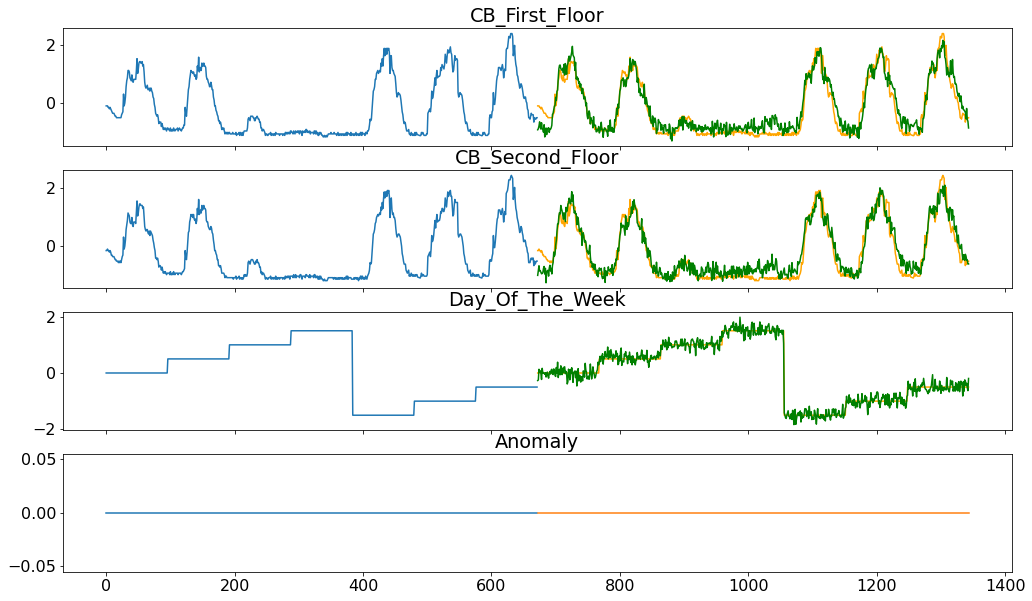

In [33]:
# Example of prediction on the test set

x = 0

w = X_test[x,:,:] 
w = tf.expand_dims(w, 0)

sample = None
encoder_mu, encoder_log_var, z, c_mean, c_log_var, c = encoder(w)
decoder_mu, decoder_log_sigma = decoder([z,c])
decoder_sigma = tf.exp(decoder_log_sigma)

a = A_test[x,:]         
pdf_laplace = tfp.distributions.Laplace(decoder_mu, decoder_sigma, validate_args=True, name='Laplace')

for _ in range(M):
    sample = pdf_laplace.sample() if sample is None else sample + pdf_laplace.sample()
reconstruction = sample/M

# Plotting predictions on the test set
target_labels = X_test_raw.columns
inspect_multivariate_prediction(w, w, a, reconstruction, target_labels, window)

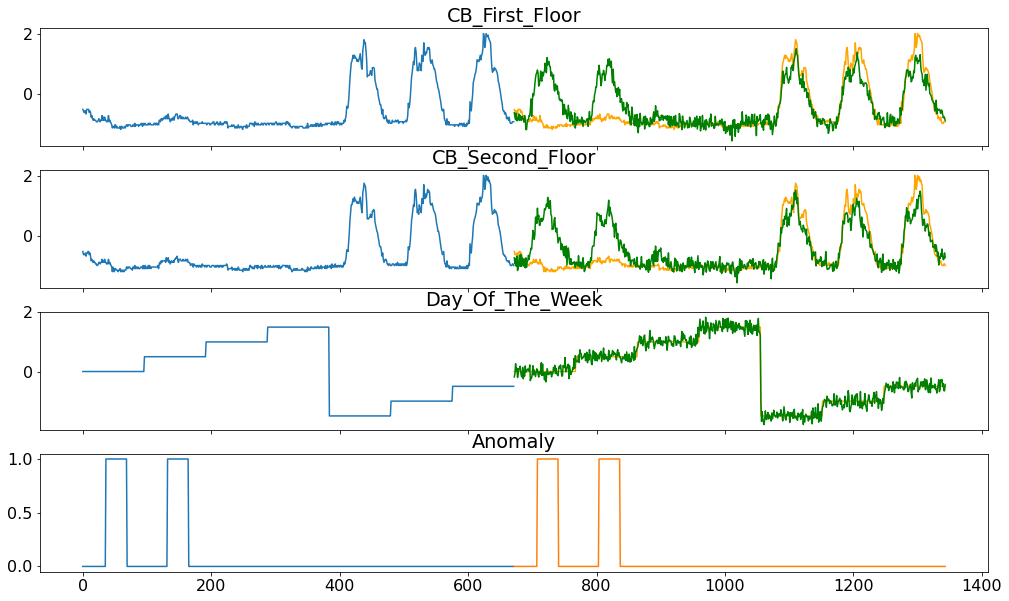

In [34]:
# Example of prediction on the test set

x = 84

w = X_test[x,:,:] 
w = tf.expand_dims(w, 0)

sample = None
encoder_mu, encoder_log_var, z, c_mean, c_log_var, c = encoder(w)
decoder_mu, decoder_log_sigma = decoder([z,c])
decoder_sigma = tf.exp(decoder_log_sigma)

a = A_test[x,:]         
pdf_laplace = tfp.distributions.Laplace(decoder_mu, decoder_sigma, validate_args=True, name='Laplace')

for _ in range(M):
    sample = pdf_laplace.sample() if sample is None else sample + pdf_laplace.sample()
reconstruction = sample/M

# Plotting predictions on the test set
target_labels = X_test_raw.columns
inspect_multivariate_prediction(w, w, a, reconstruction, target_labels, window)

## Computing reconstruction probability

In [35]:
# Function used to create non-overlapped windows starting from the TRAINING set
def build_sequences_reconstruction(df, window, stride):
    dataset = []
    temp_df = df.copy().values
    padding_len = (len(df)-window)%stride

    for idx in np.arange(0,len(temp_df)-window+1,stride):
        dataset.append(temp_df[idx:idx+window])

    dataset = np.array(dataset)
    return dataset

In [36]:
X_test_overlapped = build_sequences_reconstruction(X_test_raw, window=window, stride=stride)
X_test_overlapped.shape

(1921, 672, 3)

In [37]:
reconstructed_prob_1 = np.zeros(X_test_raw.shape[0], dtype='float32') # Array that will contain rec prob
reconstructed_prob_2 = np.zeros(X_test_raw.shape[0], dtype='float32') # Array that will contain rec prob
reconstructed_prob_written_1 = np.zeros(X_test_raw.shape[0], dtype='float32') # Array that will contain rec prob
reconstructed_prob_written_2 = np.zeros(X_test_raw.shape[0], dtype='float32') # Array that will contain rec prob
M=25

for j in range (X_test_overlapped.shape[0]): # Consider all the windows in X_test_overlapped one at a time ...
    
    if(j%100==0): print(j)
    
    w = X_test_overlapped[j,:,:] 
    w = tf.expand_dims(w, 0)
    
    z_mean, z_log_var, z, c_mean, c_log_var, c = encoder(w) # Sampling only 1 time in the latent space
    
    if (j == 0):
        
        for m in range(M):
            
            decoder_mu, decoder_log_sigma = decoder([z,c])
            decoder_sigma = tf.exp(decoder_log_sigma)
            
            for i in range(window):  
                pdf_laplace_1 = tfp.distributions.Laplace(decoder_mu[0, i, 0], decoder_sigma[0, i, 0], validate_args=True, name='Laplace1')
                pdf_laplace_2 = tfp.distributions.Laplace(decoder_mu[0, i, 1], decoder_sigma[0, i, 1], validate_args=True, name='Laplace2')
                p_l_1 = -(pdf_laplace_1.log_prob(X_test_overlapped[j, i, 0])) 
                p_l_2 = -(pdf_laplace_2.log_prob(X_test_overlapped[j, i, 1])) 
                reconstructed_prob_1[i] = reconstructed_prob_1[i] + p_l_1
                reconstructed_prob_2[i] = reconstructed_prob_2[i] + p_l_2
                reconstructed_prob_written_1[i] = reconstructed_prob_written_1[i] + 1
                reconstructed_prob_written_2[i] = reconstructed_prob_written_2[i] + 1
                
    else:
        
        for m in range(M):
            
            decoder_mu, decoder_log_sigma = decoder([z,c])
            decoder_sigma = tf.exp(decoder_log_sigma)
            
            for i in range(stride):
                pdf_laplace_1 = tfp.distributions.Laplace(decoder_mu[0, window-stride+i, 0], decoder_sigma[0, window-stride+i, 0], validate_args=True)
                pdf_laplace_2 = tfp.distributions.Laplace(decoder_mu[0, window-stride+i, 1], decoder_sigma[0, window-stride+i, 1], validate_args=True)
                p_l_1 = -(pdf_laplace_1.log_prob(X_test_overlapped[j, window-stride+i, 0]))   
                p_l_2 = -(pdf_laplace_2.log_prob(X_test_overlapped[j, window-stride+i, 1])) 
                if window + (j-1)*stride + i < X_test_raw.shape[0]: # To avoid problems related to padding
                    reconstructed_prob_1[window + (j-1) * stride + i] = reconstructed_prob_1[window + (j-1) * stride + i] + p_l_1
                    reconstructed_prob_2[window + (j-1) * stride + i] = reconstructed_prob_2[window + (j-1) * stride + i] + p_l_2
                    reconstructed_prob_written_1[window + (j-1) * stride + i] = reconstructed_prob_written_1[window + (j-1) * stride + i] + 1
                    reconstructed_prob_written_2[window + (j-1) * stride + i] = reconstructed_prob_written_2[window + (j-1) * stride + i] + 1
                    
        
reconstructed_prob_1 /= M
reconstructed_prob_2 /= M
reconstructed_prob_1.shape, reconstructed_prob_2.shape, reconstructed_prob_1.max(), reconstructed_prob_1.min(), reconstructed_prob_2.max(), reconstructed_prob_2.min()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


((16032,), (16032,), 3.5266654, 0.6931953, 3.5134733, 0.69315886)

In [38]:
reconstructed_prob_written_1.sum(), reconstructed_prob_written_2.sum(), X_test_raw.shape[0]

(400800.0, 400800.0, 16032)

In [39]:
# Checking if we've written correct things inside "reconstruction_prob"
check = True
for i in range(reconstructed_prob_written_1.shape[0]):
    if reconstructed_prob_written_1[i] != M: # Each cell written M times
        check = False
        
print(check) # If true, everything okay

True


In [40]:
# Counting the number of elements in "reconstructed_prob" that are equal to 0
counter = 0
for i in range(reconstructed_prob_1.shape[0]):
    if reconstructed_prob_1[i] == 0:
        counter += 1
        
print(counter)

0


In [41]:
reconstructed_prob = reconstructed_prob_1 + reconstructed_prob_2

In [42]:
# Function used to predict anomalies
def predict_anomalies(reconstruction_probabilities, threshold):
    
    # Inizially we don't have predicted anomalies
    anomaly_predicted = np.zeros(shape=X_test_raw.shape[0])
    
    for i in range(reconstruction_probabilities.shape[0]): 
        if reconstruction_probabilities[i] > threshold:
            anomaly_predicted[i] = 1
            
    return anomaly_predicted

In [43]:
def select_best_threshold(reconstructed_prob, step, anomaly_true):
    
    min_prob = reconstructed_prob.min()
    max_prob = reconstructed_prob.max()
    max_F1 = 0
    best_threshold = 0
    counter = 0
    
    print("best threshold = " + str(best_threshold) + ", max F1 = " + str(max_F1))
    
    thresholds = [x for x in np.arange(min_prob, max_prob, step)]
    
    for threshold in thresholds:
        
        # print("Trying threshold: " + str(threshold))
        
        if(counter<1000):
            
            anomaly_predicted = predict_anomalies(reconstructed_prob, threshold)
            f1 = f1_score(y_true=anomaly_true, y_pred=anomaly_predicted)
            if f1 > max_F1:
                max_F1 = f1
                best_threshold = threshold
                print("best threshold =" + str(best_threshold) + ", max F1 = " + str(max_F1))
            else:
                counter = counter+1
        
        else:
            return best_threshold

In [44]:
step = 1/1000
threshold = select_best_threshold(reconstructed_prob, step, Anomaly_Test)
anomaly_predicted = predict_anomalies(reconstructed_prob, threshold)

threshold, anomaly_predicted.sum(), anomaly_predicted.shape

best threshold = 0, max F1 = 0
best threshold =1.3905565738677979, max F1 = 0.06552431519247012
best threshold =1.3915565738677977, max F1 = 0.06553617765976706
best threshold =1.3925565738677976, max F1 = 0.06554013277006639
best threshold =1.3935565738677975, max F1 = 0.06554804442298406
best threshold =1.3945565738677974, max F1 = 0.06555595798623688
best threshold =1.3955565738677973, max F1 = 0.06558367051150432
best threshold =1.3965565738677972, max F1 = 0.06559951676230745
best threshold =1.397556573867797, max F1 = 0.06561933534743203
best threshold =1.398556573867797, max F1 = 0.0656431334622824
best threshold =1.3995565738677969, max F1 = 0.06567886301784094
best threshold =1.4005565738677968, max F1 = 0.06571463148977369
best threshold =1.4015565738677966, max F1 = 0.06575043894169644
best threshold =1.4025565738677965, max F1 = 0.0657862854373637
best threshold =1.4035565738677964, max F1 = 0.06584212440887595
best threshold =1.4045565738677963, max F1 = 0.0658860644300188

(3.7615565738675367, 378.0, (16032,))

In [45]:
Anomaly_Test.reset_index(inplace=True)
Anomaly_Test.drop(columns='index', inplace=True)
Anomaly_Test

,Anomaly_Label
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
16027,0.0
16028,0.0
16029,0.0
16030,0.0


In [46]:
X_test_raw.reset_index(inplace=True)
X_test_raw.drop(columns='index', inplace=True)
X_test_raw

,CB_First_Floor,CB_Second_Floor,Day_Of_The_Week
0,-0.110053,-0.145436,0.000000
1,-0.110053,-0.145436,0.000000
2,-0.110053,-0.093767,0.000000
3,-0.161507,-0.145436,0.000000
4,-0.161507,-0.145436,0.000000
...,...,...,...
16027,-0.778953,-0.765471,-0.999989
16028,-0.727499,-0.713801,-0.999989
16029,-0.676045,-0.662132,-0.999989
16030,-0.727499,-0.713801,-0.999989


In [47]:
Anomaly_Test.sum()

Anomaly_Label    543.0
dtype: float32

In [48]:
X_test_raw['Anomaly_Label_GT'] = Anomaly_Test # Ground truth anomalies
X_test_raw['Anomaly_Predicted'] = anomaly_predicted 
X_test_raw['Reconstruction_Probability'] = reconstructed_prob
X_test_raw.head()

,CB_First_Floor,CB_Second_Floor,Day_Of_The_Week,Anomaly_Label_GT,Anomaly_Predicted,Reconstruction_Probability
0,-0.110053,-0.145436,0.0,0.0,0.0,2.520272
1,-0.110053,-0.145436,0.0,0.0,0.0,2.325785
2,-0.110053,-0.093767,0.0,0.0,0.0,2.576667
3,-0.161507,-0.145436,0.0,0.0,0.0,2.448128
4,-0.161507,-0.145436,0.0,0.0,0.0,2.532604


In [49]:
# Function used to plot time series
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(30,20))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()

In [50]:
def inspect_multivariate_prediction(X, y, a_true, a_predicted, reconstruction_prob, columns): 
   
    figs, axs = plt.subplots(5, 1, sharex=True, figsize=(17,17)) 
    for i, col in enumerate(columns[:2]): 
        axs[i].plot(np.arange(len(X[:,i])), X[:,i]) 
        axs[i].plot(np.arange(len(X[:,i]), len(X[:,i])*2), y[:,i], color='orange')  
        axs[i].set_title(col) 
                 
    axs[2].plot(np.arange(len(X[:,i])), a_true) 
    axs[2].plot(np.arange(len(X[:,i]), len(X[:,i])*2), a_true) 
    axs[2].set_title('Anomaly_Label_GT') 
    
    axs[3].plot(np.arange(len(X[:,i])), a_predicted) 
    axs[3].plot(np.arange(len(X[:,i]), len(X[:,i])*2), a_predicted) 
    axs[3].set_title('Anomaly_Predicted')
    
    axs[4].plot(np.arange(len(X[:,i])), reconstruction_prob) 
    axs[4].plot(np.arange(len(X[:,i]), len(X[:,i])*2), reconstruction_prob) 
    axs[4].set_title('Reconstrution_Probability') 
    plt.show()

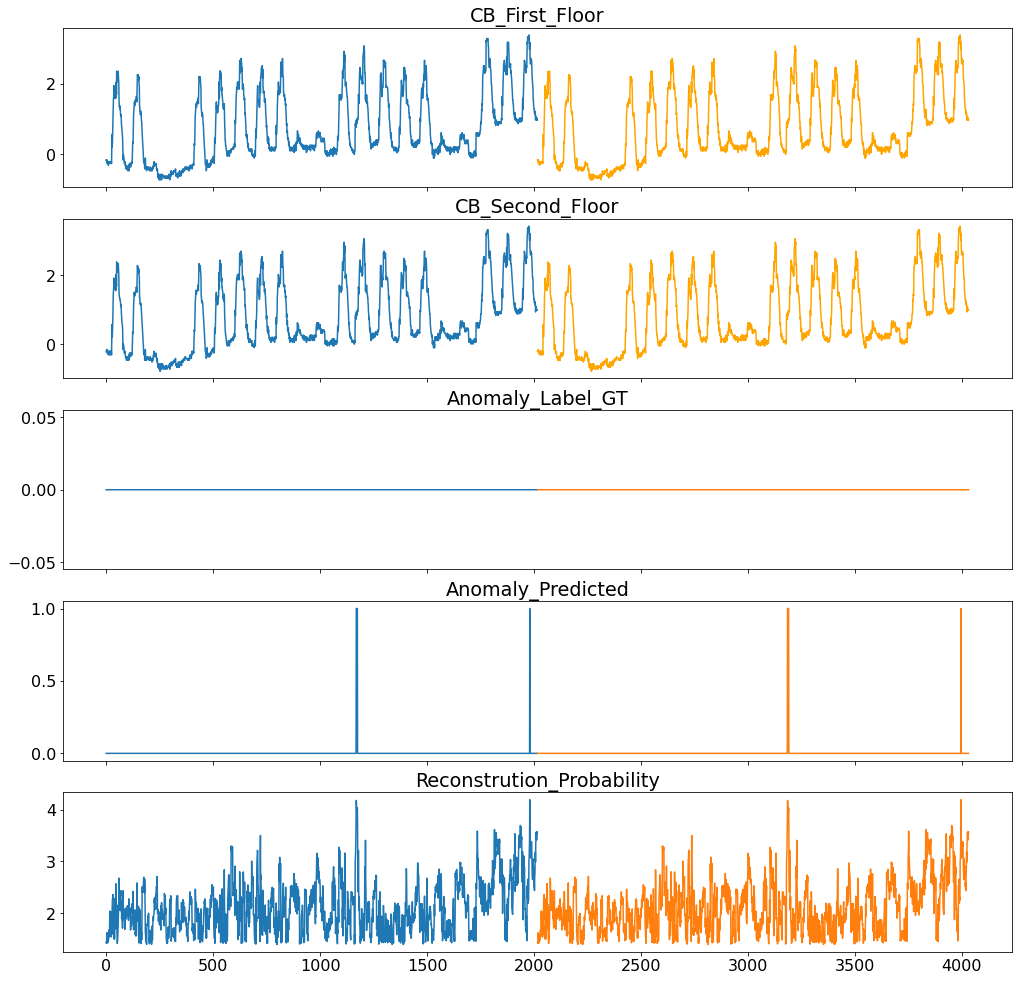

In [51]:
import datetime as dt

i=4
j=i+3

X = np.array(X_test_raw.iloc[i*672:j*672][['CB_First_Floor', 'CB_Second_Floor']])
anomaly_true = X_test_raw.iloc[i*672:j*672]['Anomaly_Label_GT'].copy()
anomaly_prediction = X_test_raw.iloc[i*672:j*672]['Anomaly_Predicted'].copy()
reconstruction_probability = X_test_raw.iloc[i*672:j*672]['Reconstruction_Probability'].copy()

# Plotting predictionsreconstruction_loss2 = tf.reduce_mean(tf.reduce_sum(tfk.losses.mse(data, y), axis=1))
inspect_multivariate_prediction(X, X, anomaly_true, anomaly_prediction, reconstruction_probability, target_labels)

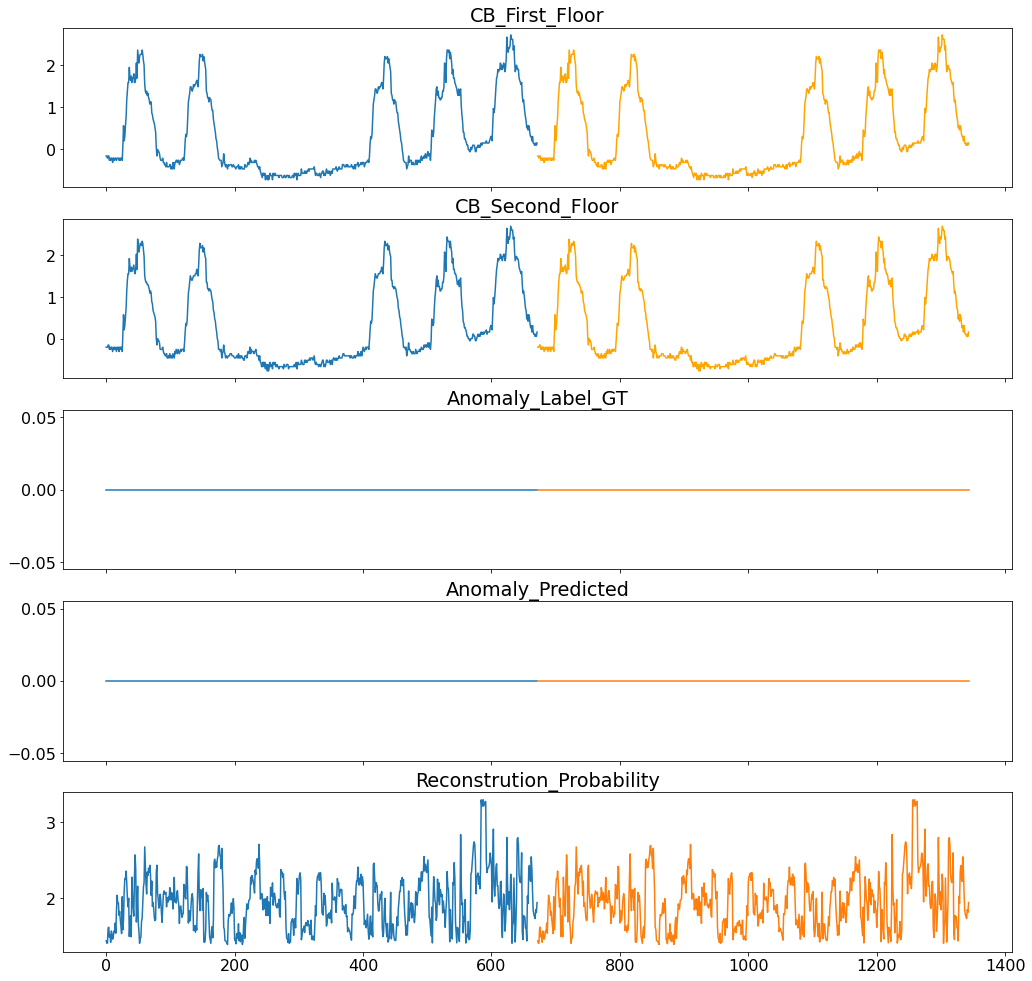

In [52]:
import datetime as dt

i=4
j=i+1

X = np.array(X_test_raw.iloc[i*672:j*672][['CB_First_Floor', 'CB_Second_Floor']])
anomaly_true = X_test_raw.iloc[i*672:j*672]['Anomaly_Label_GT'].copy()
anomaly_prediction = X_test_raw.iloc[i*672:j*672]['Anomaly_Predicted'].copy()
reconstruction_probability = X_test_raw.iloc[i*672:j*672]['Reconstruction_Probability'].copy()

# Plotting predictionsreconstruction_loss2 = tf.reduce_mean(tf.reduce_sum(tfk.losses.mse(data, y), axis=1))
inspect_multivariate_prediction(X, X, anomaly_true, anomaly_prediction, reconstruction_probability, target_labels)

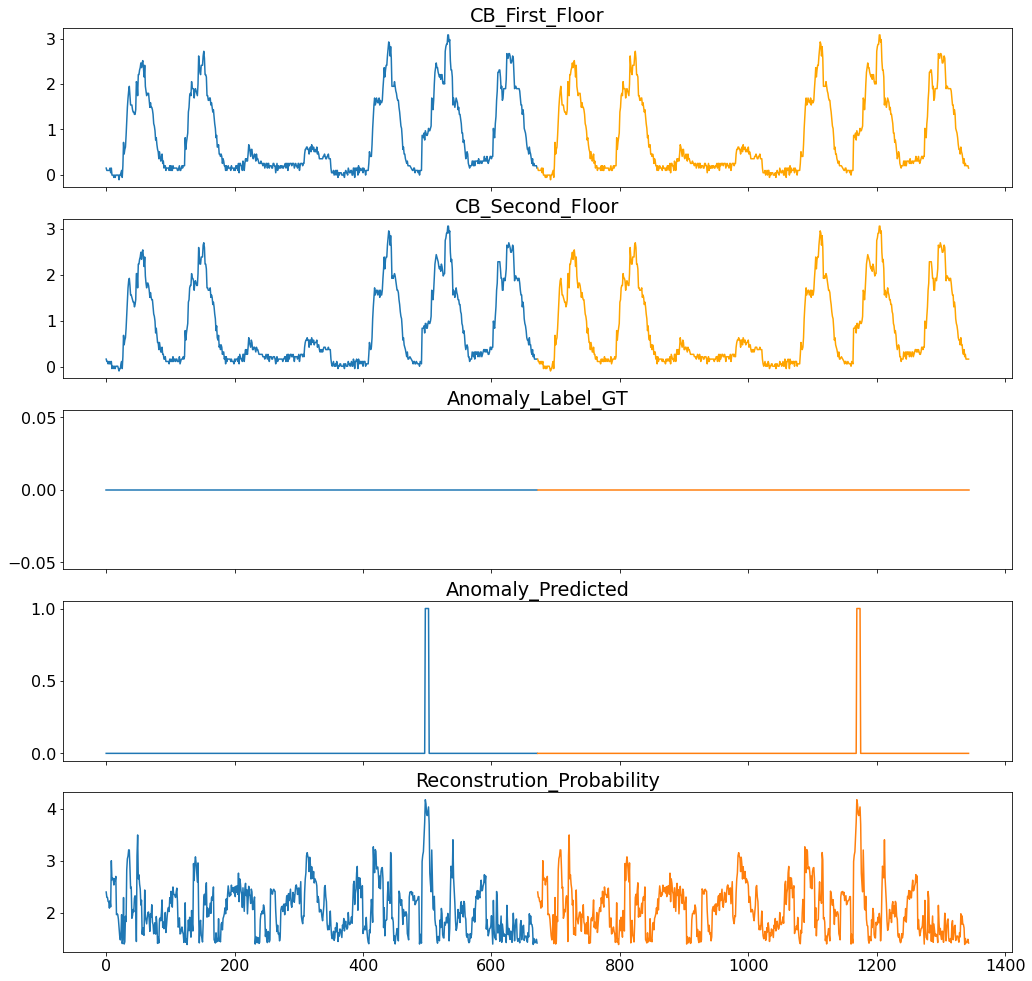

In [53]:
import datetime as dt

i=5
j=i+1

X = np.array(X_test_raw.iloc[i*672:j*672][['CB_First_Floor', 'CB_Second_Floor']])
anomaly_true = X_test_raw.iloc[i*672:j*672]['Anomaly_Label_GT'].copy()
anomaly_prediction = X_test_raw.iloc[i*672:j*672]['Anomaly_Predicted'].copy()
reconstruction_probability = X_test_raw.iloc[i*672:j*672]['Reconstruction_Probability'].copy()

# Plotting predictionsreconstruction_loss2 = tf.reduce_mean(tf.reduce_sum(tfk.losses.mse(data, y), axis=1))
inspect_multivariate_prediction(X, X, anomaly_true, anomaly_prediction, reconstruction_probability, target_labels)

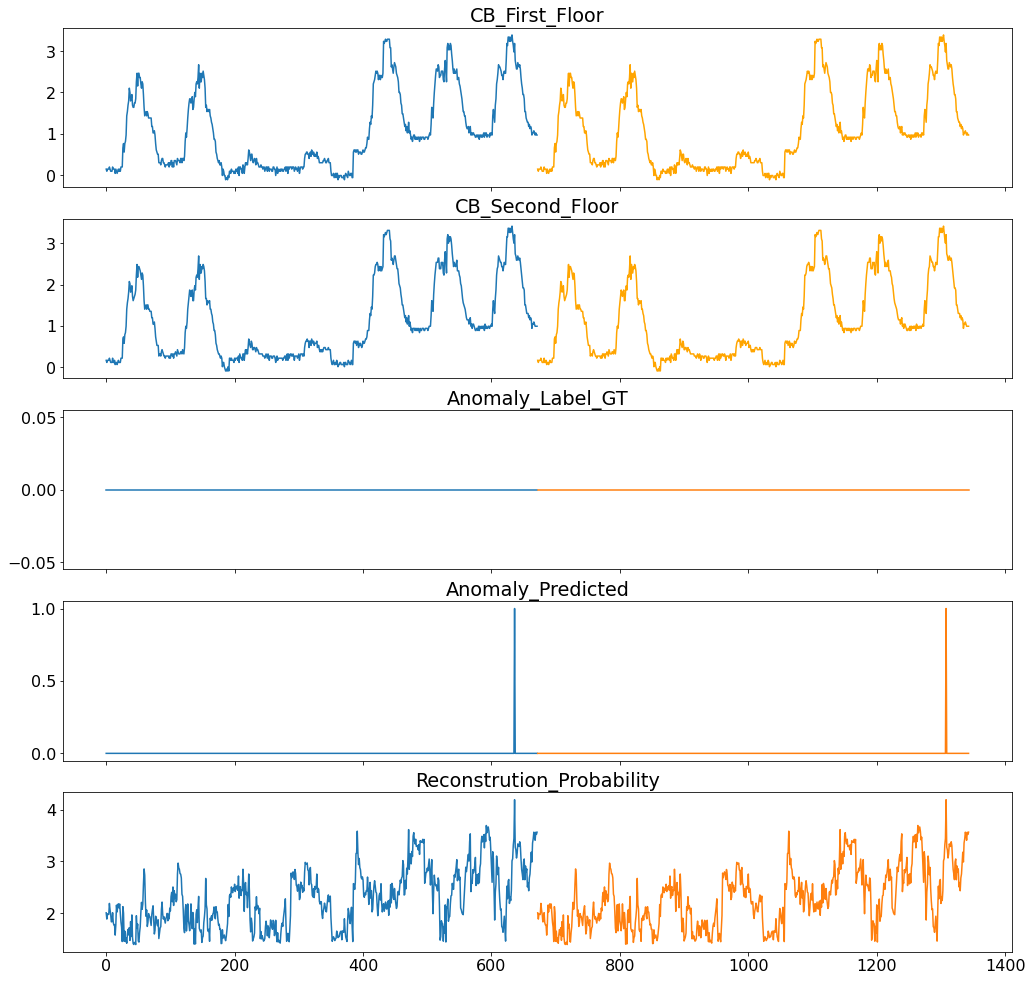

In [54]:
import datetime as dt

i=6
j=i+1

X = np.array(X_test_raw.iloc[i*672:j*672][['CB_First_Floor', 'CB_Second_Floor']])
anomaly_true = X_test_raw.iloc[i*672:j*672]['Anomaly_Label_GT'].copy()
anomaly_prediction = X_test_raw.iloc[i*672:j*672]['Anomaly_Predicted'].copy()
reconstruction_probability = X_test_raw.iloc[i*672:j*672]['Reconstruction_Probability'].copy()

# Plotting predictionsreconstruction_loss2 = tf.reduce_mean(tf.reduce_sum(tfk.losses.mse(data, y), axis=1))
inspect_multivariate_prediction(X, X, anomaly_true, anomaly_prediction, reconstruction_probability, target_labels)

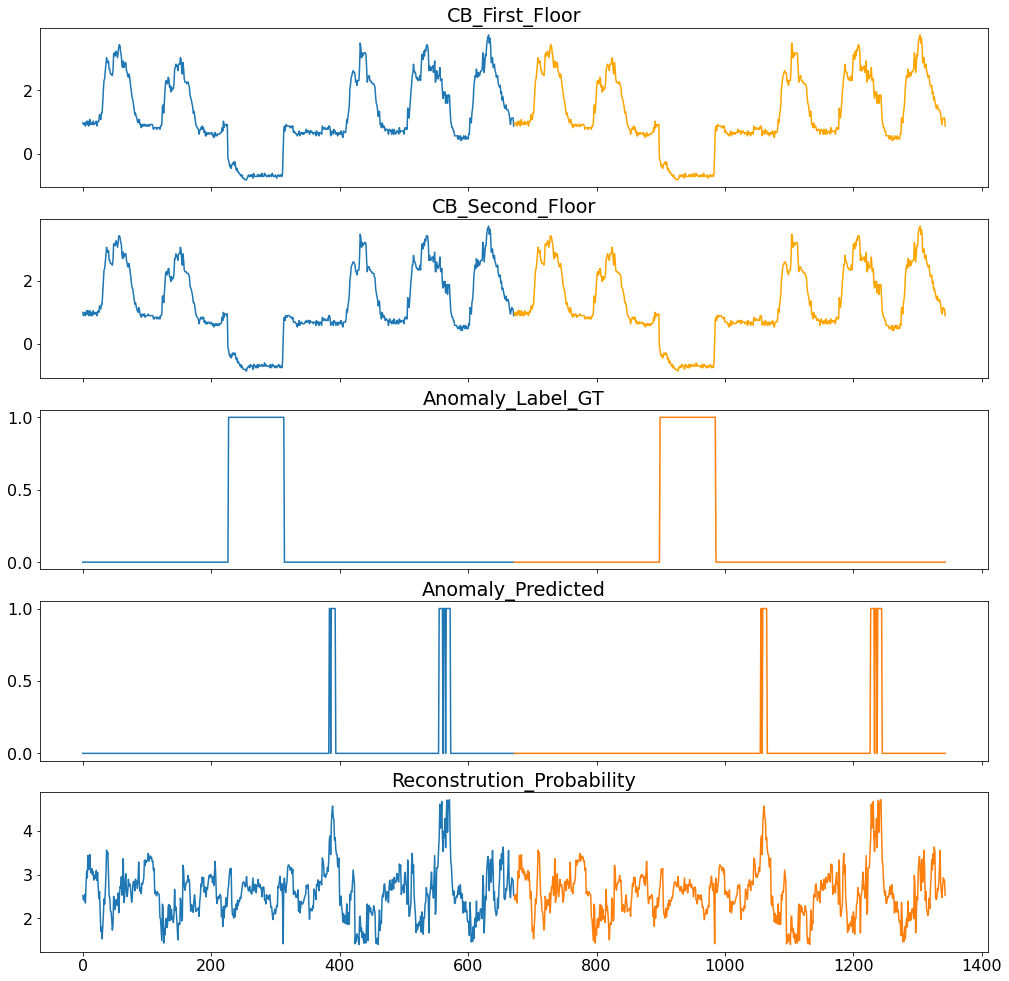

In [55]:
import datetime as dt

i=7
j=i+1

X = np.array(X_test_raw.iloc[i*672:j*672][['CB_First_Floor', 'CB_Second_Floor']])
anomaly_true = X_test_raw.iloc[i*672:j*672]['Anomaly_Label_GT'].copy()
anomaly_prediction = X_test_raw.iloc[i*672:j*672]['Anomaly_Predicted'].copy()
reconstruction_probability = X_test_raw.iloc[i*672:j*672]['Reconstruction_Probability'].copy()

# Plotting predictionsreconstruction_loss2 = tf.reduce_mean(tf.reduce_sum(tfk.losses.mse(data, y), axis=1))
inspect_multivariate_prediction(X, X, anomaly_true, anomaly_prediction, reconstruction_probability, target_labels)

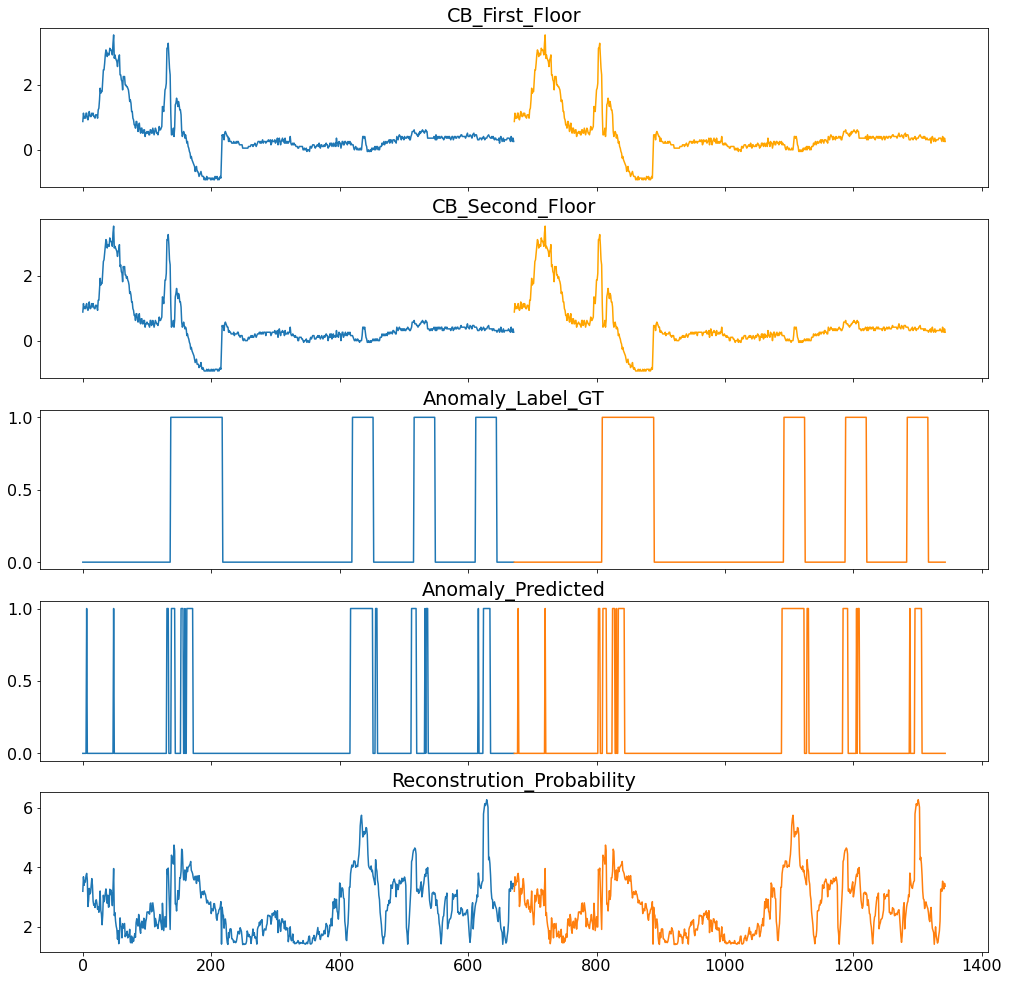

In [56]:
import datetime as dt

i=8
j=i+1

X = np.array(X_test_raw.iloc[i*672:j*672][['CB_First_Floor', 'CB_Second_Floor']])
anomaly_true = X_test_raw.iloc[i*672:j*672]['Anomaly_Label_GT'].copy()
anomaly_prediction = X_test_raw.iloc[i*672:j*672]['Anomaly_Predicted'].copy()
reconstruction_probability = X_test_raw.iloc[i*672:j*672]['Reconstruction_Probability'].copy()

# Plotting predictionsreconstruction_loss2 = tf.reduce_mean(tf.reduce_sum(tfk.losses.mse(data, y), axis=1))
inspect_multivariate_prediction(X, X, anomaly_true, anomaly_prediction, reconstruction_probability, target_labels)

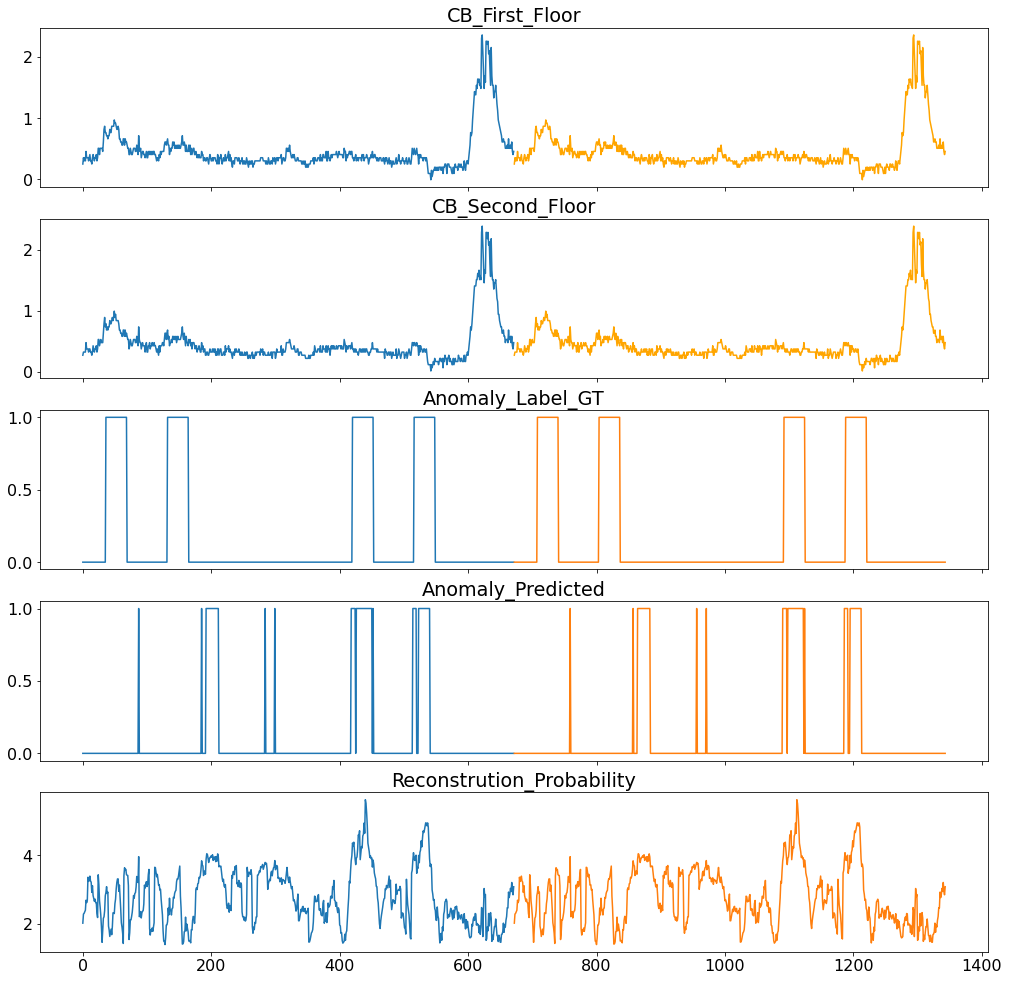

In [57]:
import datetime as dt

i=9
j=i+1

X = np.array(X_test_raw.iloc[i*672:j*672][['CB_First_Floor', 'CB_Second_Floor']])
anomaly_true = X_test_raw.iloc[i*672:j*672]['Anomaly_Label_GT'].copy()
anomaly_prediction = X_test_raw.iloc[i*672:j*672]['Anomaly_Predicted'].copy()
reconstruction_probability = X_test_raw.iloc[i*672:j*672]['Reconstruction_Probability'].copy()

# Plotting predictionsreconstruction_loss2 = tf.reduce_mean(tf.reduce_sum(tfk.losses.mse(data, y), axis=1))
inspect_multivariate_prediction(X, X, anomaly_true, anomaly_prediction, reconstruction_probability, target_labels)

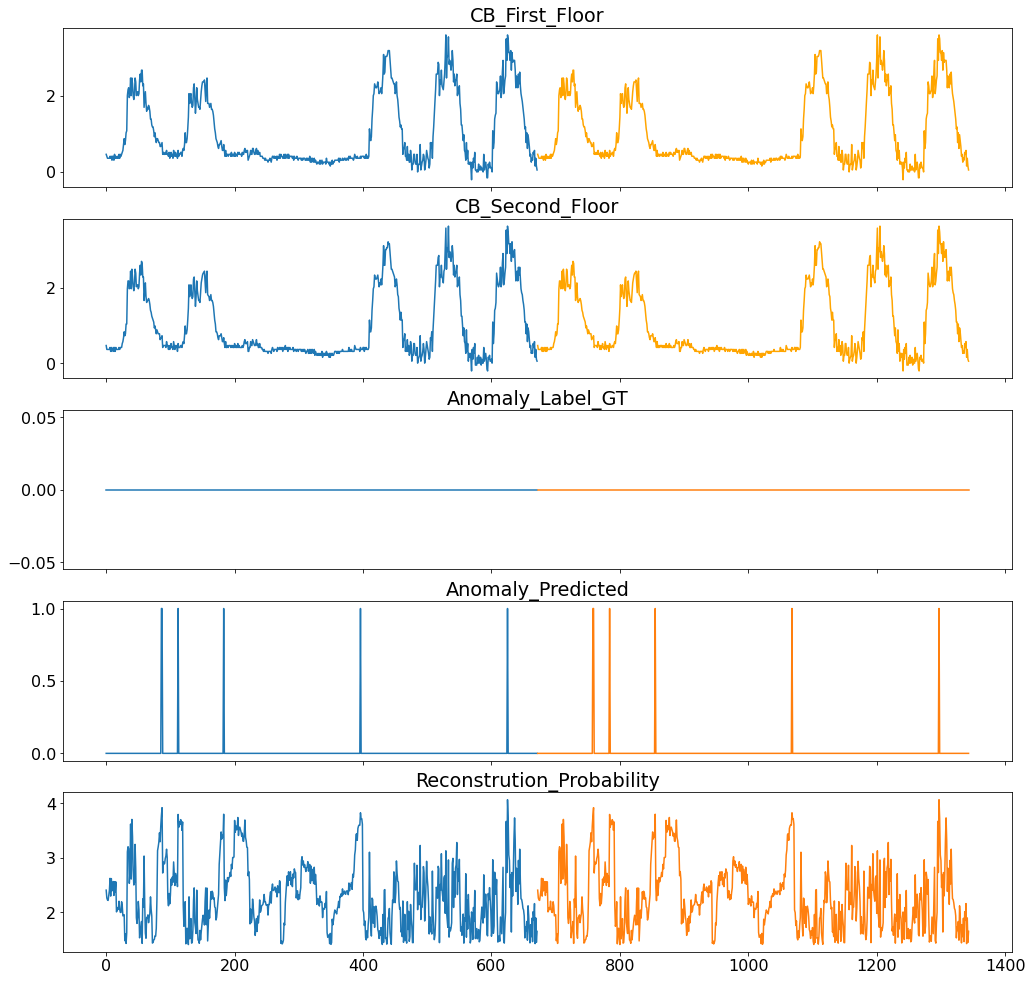

In [58]:
import datetime as dt

i=10
j=i+1

X = np.array(X_test_raw.iloc[i*672:j*672][['CB_First_Floor', 'CB_Second_Floor']])
anomaly_true = X_test_raw.iloc[i*672:j*672]['Anomaly_Label_GT'].copy()
anomaly_prediction = X_test_raw.iloc[i*672:j*672]['Anomaly_Predicted'].copy()
reconstruction_probability = X_test_raw.iloc[i*672:j*672]['Reconstruction_Probability'].copy()

# Plotting predictionsreconstruction_loss2 = tf.reduce_mean(tf.reduce_sum(tfk.losses.mse(data, y), axis=1))
inspect_multivariate_prediction(X, X, anomaly_true, anomaly_prediction, reconstruction_probability, target_labels)

Accuracy: 0.9697
Precision: 0.5767
Recall: 0.4015
F1: 0.4734


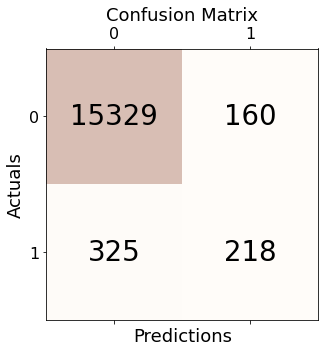

In [59]:
anomaly_predicted = anomaly_predicted

# Compute the confusion matrix
cm = confusion_matrix(y_true=Anomaly_Test, y_pred=anomaly_predicted)

# Compute the classification metrics
accuracy = accuracy_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
precision = precision_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
recall = recall_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
f1 = f1_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
        
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()